# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders, discard_random_labels, remove_duplicates_preserve_order, order_labels_and_array_with_target
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics, plot_corr_matrix, get_experiment_data
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, find_nearest_orbits_batch, calculate_pairwise_orbit_distances, calculate_distances_batch, find_nearest_points_batch, calculate_pairwise_distances, find_nearest_orbits
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits
from orbit_generation.architectures import Sampling

In [3]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Parameters

In [4]:
want_to_train = False   # Set this parameter to False if you want to load the model from the folder
want_to_generate = False    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = False   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = False    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = False   # Set this parameter to False if you don't want to perform convergence
want_to_discover = False            # Set this parameter to False if you don't want to study the discovery

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.0003, ##change back
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 20,
    'families_to_discard' : 4
}

# Saving paths

In [7]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_16


In [8]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [9]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [10]:
if params['feature_dim']==6:
    full_data=full_data[:,1:,:]
    full_data.shape

Remove specific families from the training data

In [11]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

if want_to_discover:
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), params['families_to_discard'])
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_families)]
    add_experiment_metrics(experiments_folder, params=params,
                           metrics={'discarded_family_ids':discarded_family_ids, 'discarded_families':discarded_families})

else:
    experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
    discarded_family_ids = experiment_data.get('discarded_family_ids', {})
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

['S_DPO', 'S_LPOW', 'S_R21', 'S_R32']

Get Features

In [12]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Scaling

In [13]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([40716, 7, 100])

# Modelling

In [14]:
model = get_model(params)

In [15]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

In [16]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

# Latent Space

## Dataset

In [17]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


(40716, 4)

In [ ]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

In [ ]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names,
                            plot_std=True,
                            latent_stdevs=latent_stdevs)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

### Full Dataset

## Centroids

In [ ]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(36, 4)

In [19]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

36

In [20]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([-0.20931575, -0.0250319 ], dtype=float32)

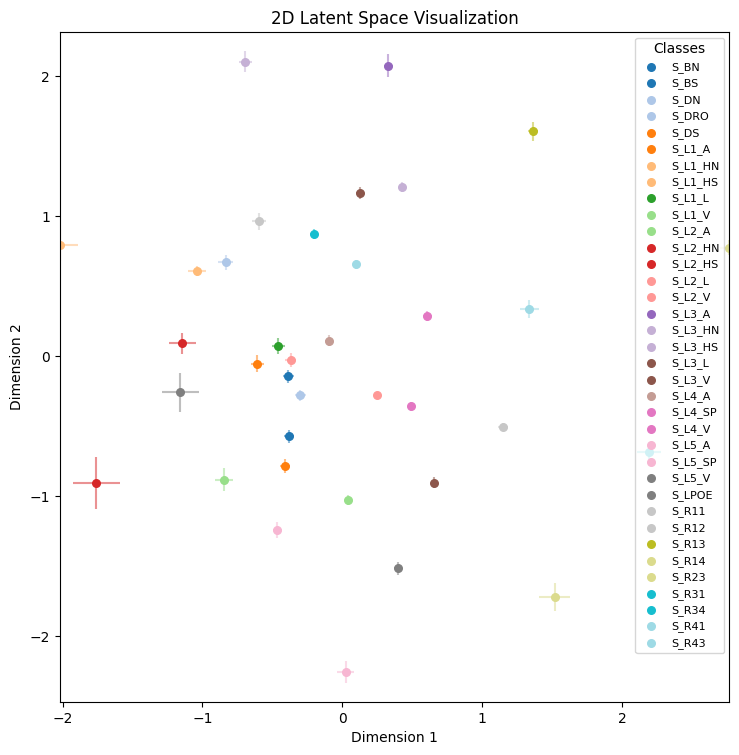

In [22]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path,
                            latent_stdevs=centroid_stdevs
                            )
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

## Clustering

In [23]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

# Generation

In [24]:
# z = Sampling(z_mean, z_log_var)

In [25]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

(100, 7, 100)

## Visualization

In [26]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

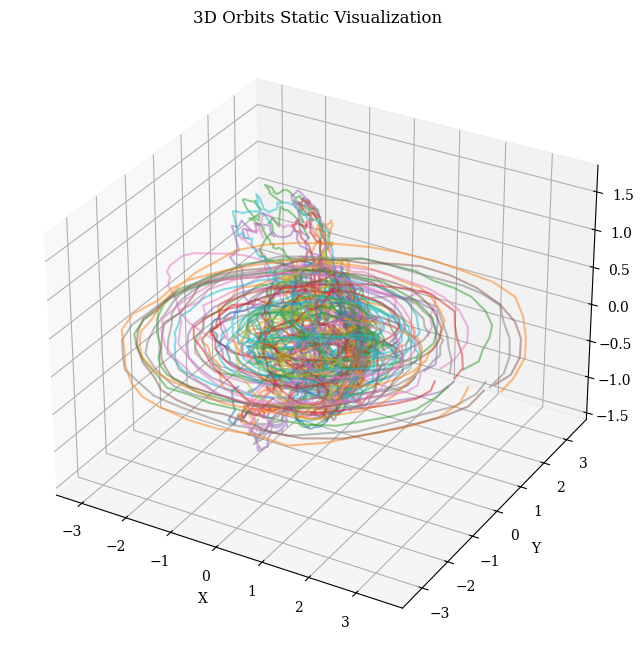

In [27]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

In [28]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_16/images/exp16_generated_orbits.html


## Coverage

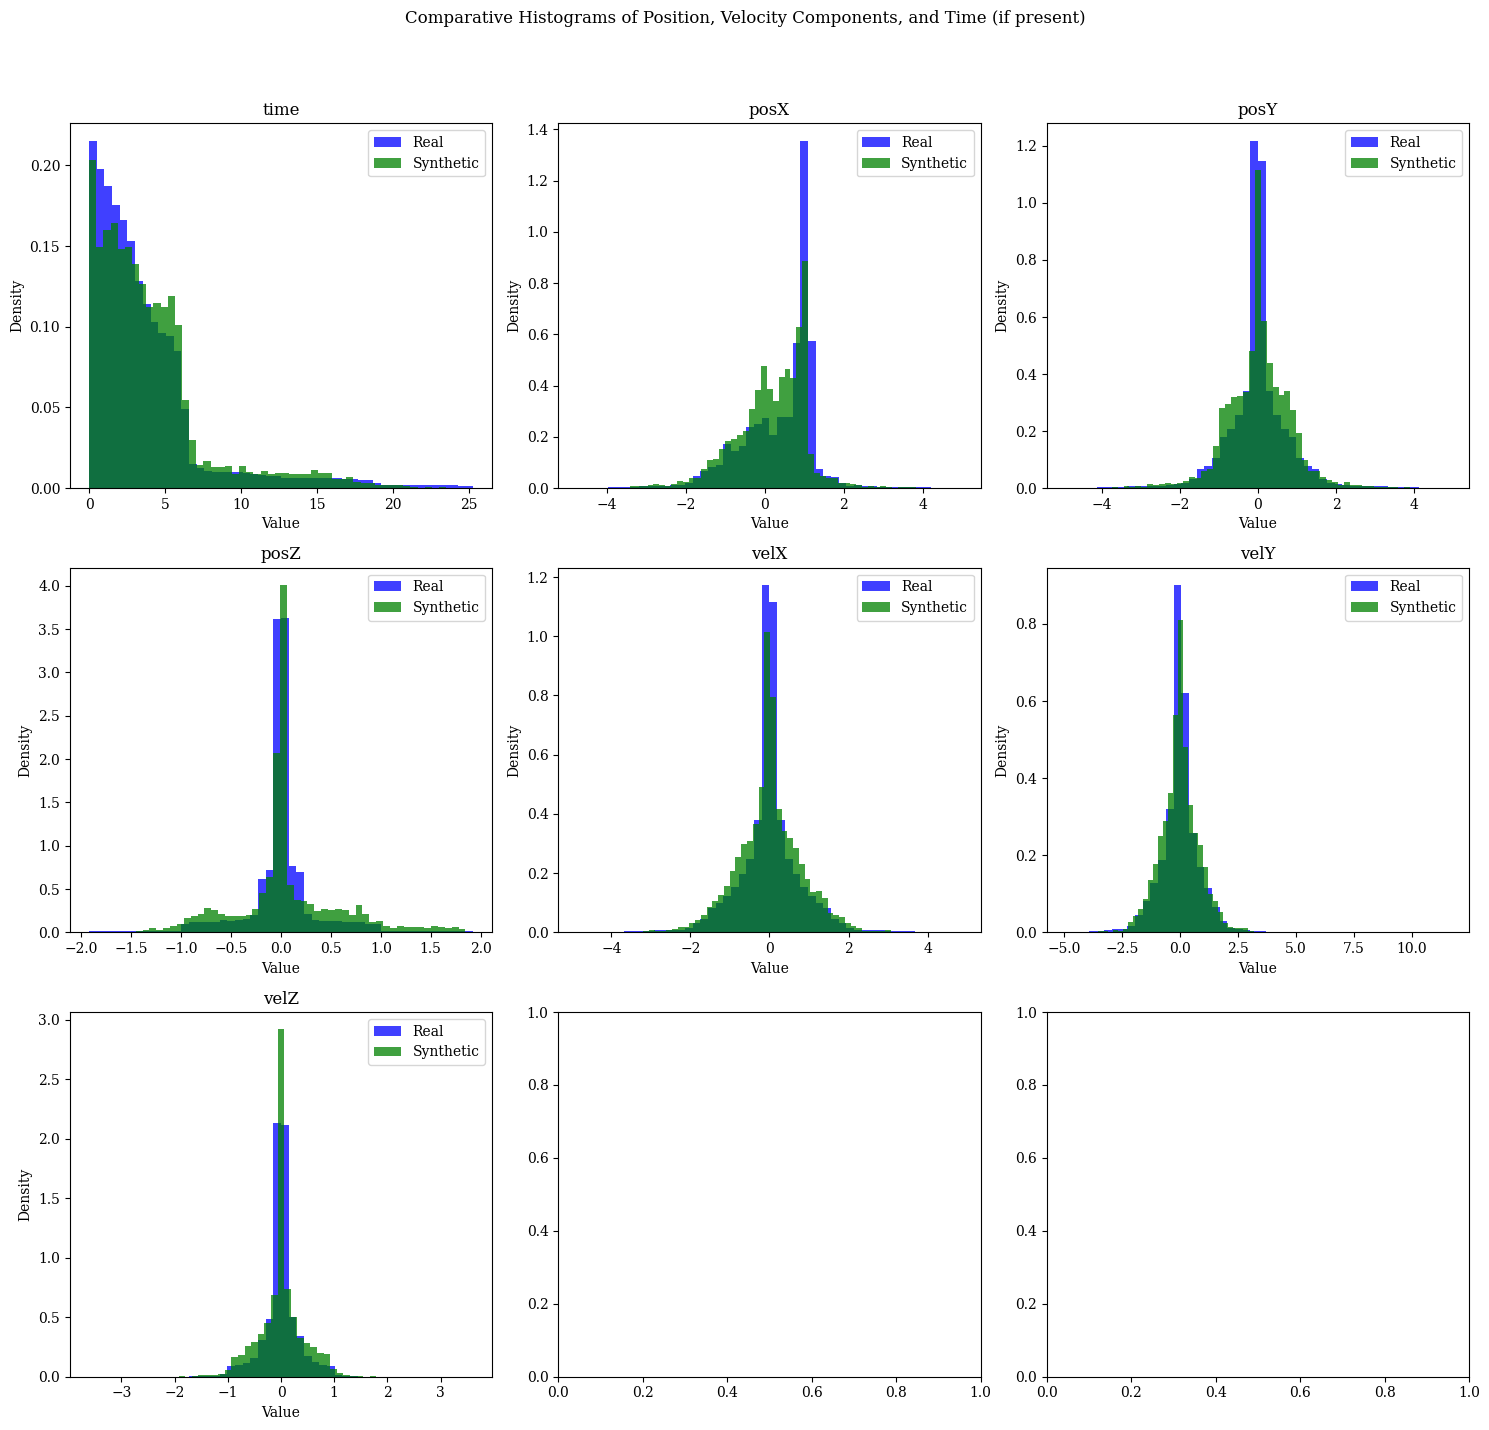

In [29]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

In [ ]:
plot_histograms_comparison(data1=full_data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=full_histogram_comparison_path)

## Pheasibility

In [30]:
if calculate_error_metrics:

    #Order metrics
    reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
    average_order_metrics = order_metrics_array.mean(axis=0)
    average_order_metrics_dict = dict(zip(order_metric_labels, average_order_metrics))

    # Pheasibility metrics
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    generation_df = pd.DataFrame(per_orbit_errors)
    new_values_df = pd.DataFrame(order_metrics_array, columns=order_metric_labels)
    generation_df = pd.concat([generation_df, new_values_df], axis=1)

    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **average_order_metrics_dict})

else:
    generation_df = pd.read_csv(generation_df_path)



In [31]:
generation_df.head()

,position_error,velocity_error,energy_error,disorder_metric,correct_order,inversions,kendall_tau_distance,nearest_orbit,nearest_orbit_distance
0,0.117858,0.196755,0.264491,96.0,79.0,56.0,0.022626,18866,2.079341
1,0.293537,0.536004,1.663072,232.0,69.0,150.0,0.060606,19880,3.622663
2,0.316410,0.642480,0.867894,188.0,74.0,122.0,0.049293,30368,4.237964
3,0.121632,0.219787,0.237567,82.0,77.0,45.0,0.018182,27691,3.441835
4,0.327133,0.660935,0.335884,574.0,61.0,409.0,0.165253,8382,2.569475


# Convergence

In [32]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(reordered_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)
    refined_orbits_df = pd.read_csv(refined_orbits_df_path)

refined_orbits.shape

(53, 7, 100)

Order Metrics

In [33]:
# Order orbits and average metrics
reordered_refined_orbits, refined_order_metrics_array, refined_order_metric_labels = reorder_orbits(refined_orbits)
refined_average_order_metrics = refined_order_metrics_array.mean(axis=0)
refined_order_metrics = dict(zip(refined_order_metric_labels, refined_average_order_metrics))

# Add individual metrics to the df
new_values_df = pd.DataFrame(refined_order_metrics_array, columns=refined_order_metric_labels)
refined_orbits_df = pd.concat([refined_orbits_df, new_values_df], axis=1)

refined_order_metrics

{'disorder_metric': np.float64(136.83018867924528),
 'correct_order': np.float64(76.0754716981132),
 'inversions': np.float64(87.73584905660377),
 'kendall_tau_distance': np.float64(0.035448827901657945)}

Pheasibility Metrics

In [34]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

{'position_error': np.float64(2.8193979352748344e-12),
 'velocity_error': np.float64(6.328821861245238e-12),
 'energy_error': np.float64(1.1385547651533174e-11)}

In [35]:
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,disorder_metric.1,correct_order.1,inversions.1,kendall_tau_distance.1,disorder_metric.2,correct_order.2,inversions.2,kendall_tau_distance.2,disorder_metric,correct_order,inversions,kendall_tau_distance
0,0,6.681508,6.191982,6,4.006926e-10,1.043924,0.054178,0.089535,-0.069958,-0.541429,0.809974,1.068614,-0.062671,0.086892,-0.194351,-0.625872,0.883630,72.0,77.0,44.0,0.017778,2.047522e-12,1.169630e-11,4.985415e-11,0.074820,1.947843,0.489526,18870,0.000431,18875,1.727010,2.347987,0.281944,1.155201,14,0.235557,29,0.136187,0.205670,72.0,77.0,44.0,0.017778,72.0,77.0,44.0,0.017778,72.0,77.0,44.0,0.017778
1,2,6.343020,6.310494,8,4.644930e-12,0.635513,-0.472652,0.313986,-0.619190,-1.407142,-0.532716,0.812518,-0.065665,0.576976,0.133974,-1.711637,-0.387909,168.0,78.0,102.0,0.041212,8.925106e-13,3.473907e-12,2.808833e-12,0.039650,-0.422727,0.032526,27145,0.000384,30386,6.760775,6.755768,1.516221,2.979801,25,0.144927,20,0.653509,0.973177,168.0,78.0,102.0,0.041212,168.0,78.0,102.0,0.041212,168.0,78.0,102.0,0.041212
2,3,6.553319,6.301689,9,2.944897e-10,0.493051,0.341944,0.638089,-0.075344,-0.885442,0.536099,0.723095,0.438712,0.523782,-0.108172,-0.800060,0.828746,62.0,76.0,38.0,0.015354,7.601409e-12,1.895780e-11,9.551470e-11,0.027215,1.390312,0.251631,27652,0.000109,27694,2.351857,3.275253,0.558098,1.390368,22,0.312893,18,0.350182,0.411534,62.0,76.0,38.0,0.015354,62.0,76.0,38.0,0.015354,62.0,76.0,38.0,0.015354
3,6,6.534883,6.230362,14,3.000276e-10,-1.439398,0.155306,1.246092,0.030485,0.879167,-0.010162,-1.317152,0.006900,1.221216,0.006212,0.991039,-0.001477,178.0,73.0,107.0,0.043232,1.775829e-12,7.277053e-12,8.471915e-12,0.066721,1.879466,0.304521,21937,0.000049,20909,3.031166,4.472930,1.361228,1.149586,16,0.030233,29,0.176090,0.225316,178.0,73.0,107.0,0.043232,178.0,73.0,107.0,0.043232,178.0,73.0,107.0,0.043232
4,8,7.089235,6.189303,9,2.072527e-10,1.003943,-0.125944,-0.110756,-0.022212,-0.479927,-0.888967,0.892827,0.006733,0.015941,-0.002520,-0.425069,-1.006236,68.0,83.0,41.0,0.016566,3.055794e-12,8.617879e-12,8.542796e-13,0.035552,2.050338,0.899932,12479,0.000580,12483,1.313620,2.182510,0.989781,1.121241,9,0.139429,29,0.096500,0.251299,68.0,83.0,41.0,0.016566,68.0,83.0,41.0,0.016566,68.0,83.0,41.0,0.016566


In [36]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(53, 7, 100)

## Visualization

Generation that was able to get Refined

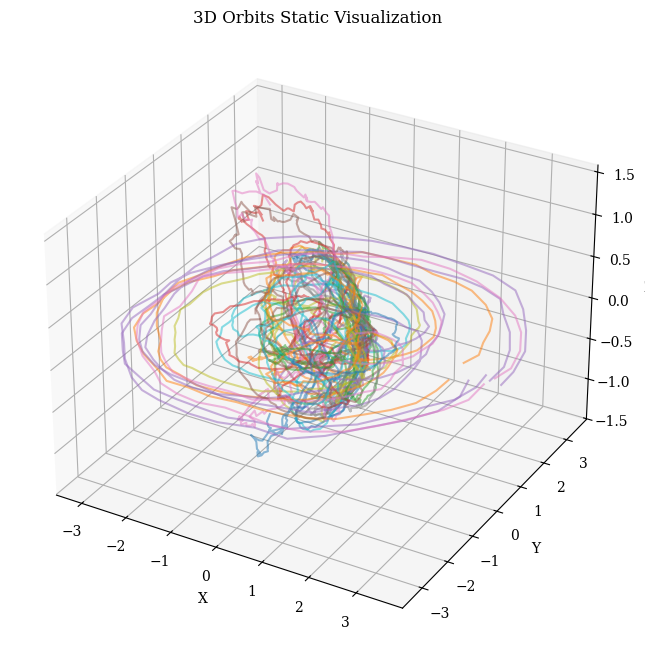

In [37]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

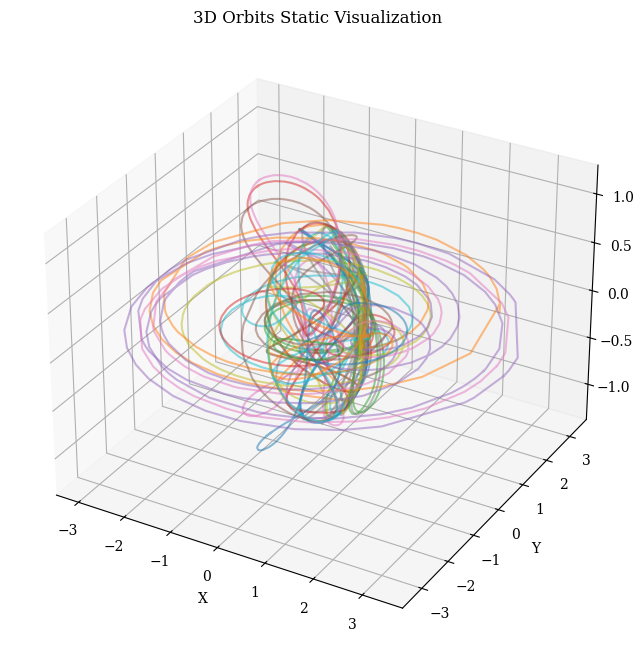

In [38]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [39]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(47, 7, 100)

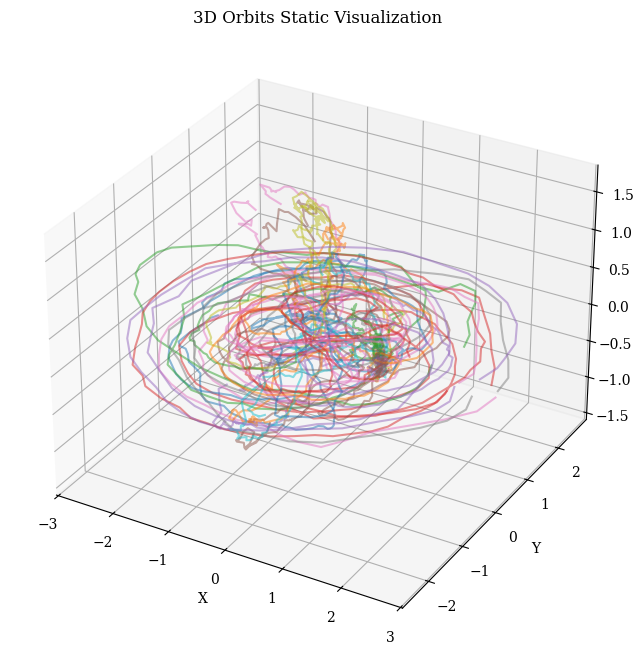

In [40]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

## Latent Space

In [41]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_means = refined_latent_means.detach().numpy()
refined_latent_log_vars = refined_latent_log_vars.detach().numpy()
refined_latent_representations = np.concatenate((refined_latent_means, refined_latent_log_vars), axis=1)
refined_latent_representations.shape

(53, 4)

Saved plot to ../experiments/experiment_16/images/exp16_combined_latent_space


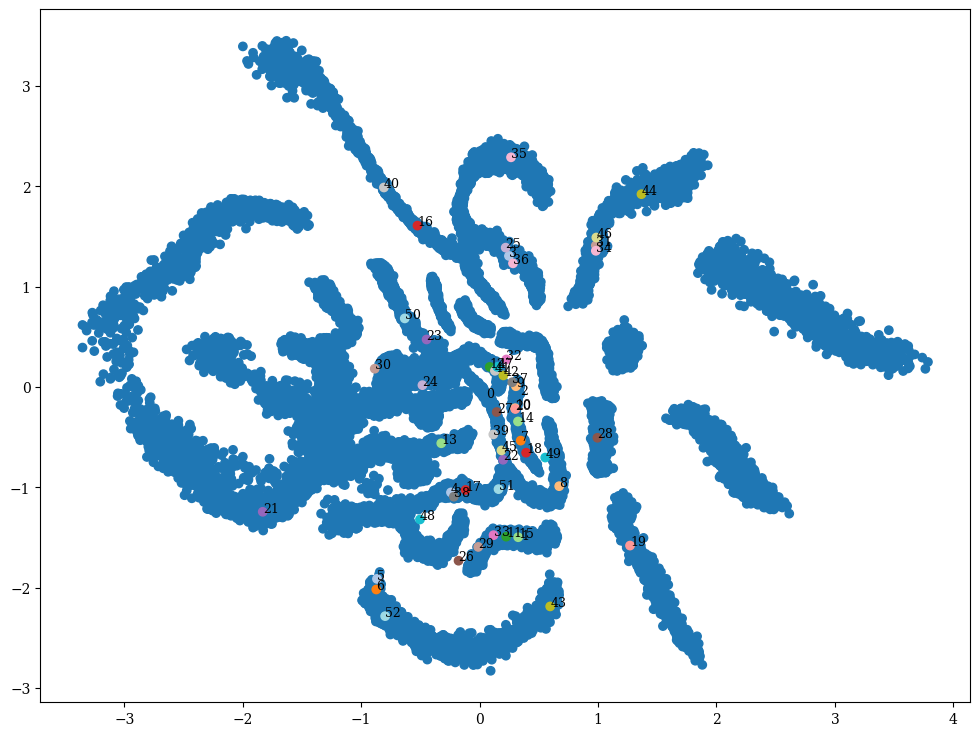

In [42]:
if refined_latent_means.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_means)
    latent_representation=rls['PCA']['train']
    refined_latent_means=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_means,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [43]:
scaled_generation = scaler.transform(torch.from_numpy(generation).float())
latent_generation_means, _ = model.encode(scaled_generation)
latent_generation_means = latent_generation_means.detach().numpy()
latent_generation_means_that_refined = latent_generation_means[refined_ids]
generation_to_refinement = np.stack((latent_generation_means_that_refined, refined_latent_means), axis=1)
generation_to_refinement.shape

(53, 2, 2)

Saved plot to ../experiments/experiment_16/images/exp16_combined_latent_space_arrows


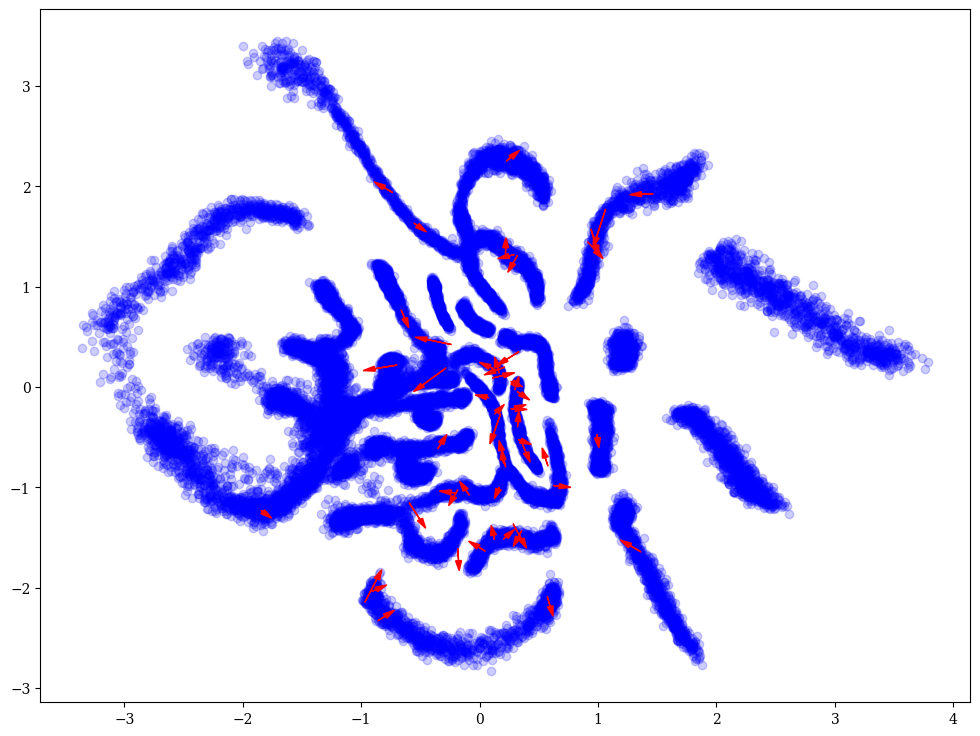

In [44]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement,
    annotation_mode='numbers',
    save_path=combined_latent_space_arrows_path
)

In [45]:
generation_to_refinement_latent_distance = calculate_pairwise_distances(latent_generation_means_that_refined, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['latent_distance_to_generation'] = generation_to_refinement_latent_distance

## Features

Calculate Jacobi Constant on the dataset

In [46]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

full_orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [47]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,disorder_metric.1,correct_order.1,inversions.1,kendall_tau_distance.1,disorder_metric.2,correct_order.2,inversions.2,kendall_tau_distance.2,disorder_metric,correct_order,inversions,kendall_tau_distance
0,0,6.681508,6.191982,6,4.006926e-10,1.043924,0.054178,0.089535,-0.069958,-0.541429,0.809974,1.068614,-0.062671,0.086892,-0.194351,-0.625872,0.883630,72.0,77.0,44.0,0.017778,2.047522e-12,1.169630e-11,4.985415e-11,0.017770,1.947843,0.489526,18870,0.000431,18875,1.727010,2.347987,0.281944,1.155201,14,0.235557,29,0.136187,0.205670,72.0,77.0,44.0,0.017778,72.0,77.0,44.0,0.017778,72.0,77.0,44.0,0.017778
1,2,6.343020,6.310494,8,4.644930e-12,0.635513,-0.472652,0.313986,-0.619190,-1.407142,-0.532716,0.812518,-0.065665,0.576976,0.133974,-1.711637,-0.387909,168.0,78.0,102.0,0.041212,8.925106e-13,3.473907e-12,2.808833e-12,0.167845,-0.422727,0.032526,27145,0.000384,30386,6.760775,6.755768,1.516221,2.979801,25,0.144927,20,0.653509,0.973177,168.0,78.0,102.0,0.041212,168.0,78.0,102.0,0.041212,168.0,78.0,102.0,0.041212
2,3,6.553319,6.301689,9,2.944897e-10,0.493051,0.341944,0.638089,-0.075344,-0.885442,0.536099,0.723095,0.438712,0.523782,-0.108172,-0.800060,0.828746,62.0,76.0,38.0,0.015354,7.601409e-12,1.895780e-11,9.551470e-11,0.035704,1.390312,0.251631,27652,0.000109,27694,2.351857,3.275253,0.558098,1.390368,22,0.312893,18,0.350182,0.411534,62.0,76.0,38.0,0.015354,62.0,76.0,38.0,0.015354,62.0,76.0,38.0,0.015354
3,6,6.534883,6.230362,14,3.000276e-10,-1.439398,0.155306,1.246092,0.030485,0.879167,-0.010162,-1.317152,0.006900,1.221216,0.006212,0.991039,-0.001477,178.0,73.0,107.0,0.043232,1.775829e-12,7.277053e-12,8.471915e-12,0.045574,1.879466,0.304521,21937,0.000049,20909,3.031166,4.472930,1.361228,1.149586,16,0.030233,29,0.176090,0.225316,178.0,73.0,107.0,0.043232,178.0,73.0,107.0,0.043232,178.0,73.0,107.0,0.043232
4,8,7.089235,6.189303,9,2.072527e-10,1.003943,-0.125944,-0.110756,-0.022212,-0.479927,-0.888967,0.892827,0.006733,0.015941,-0.002520,-0.425069,-1.006236,68.0,83.0,41.0,0.016566,3.055794e-12,8.617879e-12,8.542796e-13,0.042371,2.050338,0.899932,12479,0.000580,12483,1.313620,2.182510,0.989781,1.121241,9,0.139429,29,0.096500,0.251299,68.0,83.0,41.0,0.016566,68.0,83.0,41.0,0.016566,68.0,83.0,41.0,0.016566


Compare Features between Dataset and Refinement

Saved plot to ../experiments/experiment_16/images/exp16_features


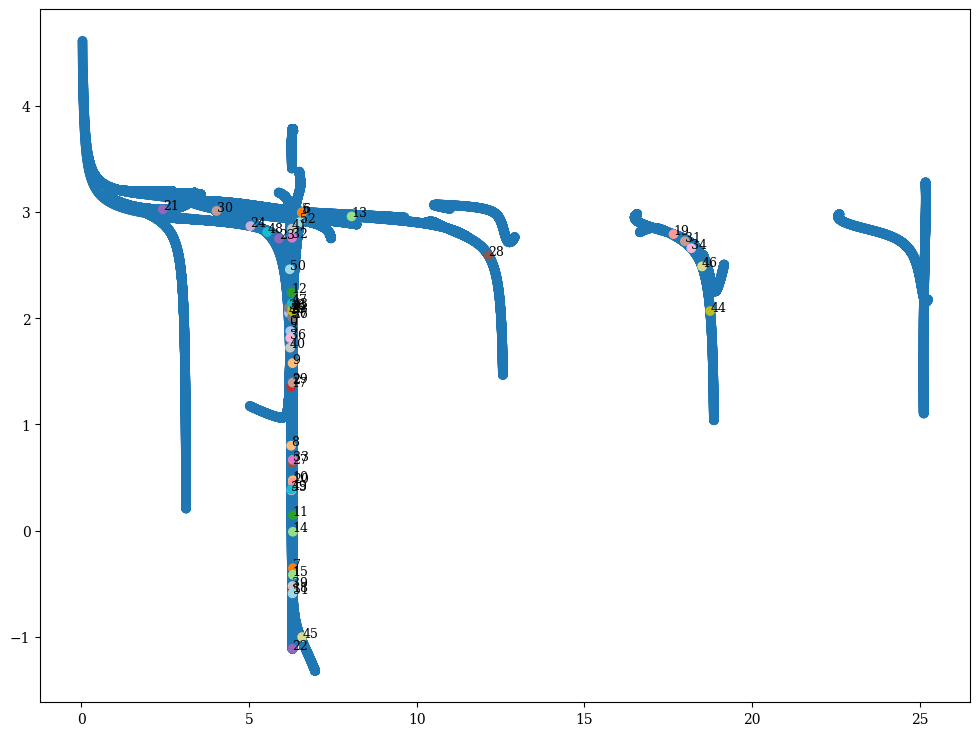

In [48]:
features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values 

closest_feature_indices, feature_distances = find_nearest_points_batch(refined_orbits_features, dataset_features,
                                                                       n=1, distance_metric=params['distance_metric'])

refined_orbits_df['feature_closest_orbit'] = closest_feature_indices
refined_orbits_df['feature_distance_from_closest_orbit'] = feature_distances

plot_combined_2d_latent_space(dataset_features, refined_orbits_features,
                              synthetic_labels=list(range(0, len(refined_scaled_data))),
                              annotation_mode='numbers', save_path=features_plot_path)

Feature Centroids

In [49]:
array_features = full_orbit_df[features_used].to_numpy()
feature_centroid = full_orbit_df[features_used].mean().to_numpy()
feature_centroids = compute_centroids(array_features, full_orbits_id_classes, method='mean')
feature_centroids.shape

(40, 2)

In [50]:
stdev_feature_centroids  = full_orbit_df.groupby('id_class')[features_used].std().values
stdev_feature_centroids.shape

(40, 2)

In [51]:
feature_centroid = full_orbit_df[features_used].mean().values
feature_centroid.shape

(2,)

In [52]:
full_unique_classes = list(set(full_orbits_id_classes))
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

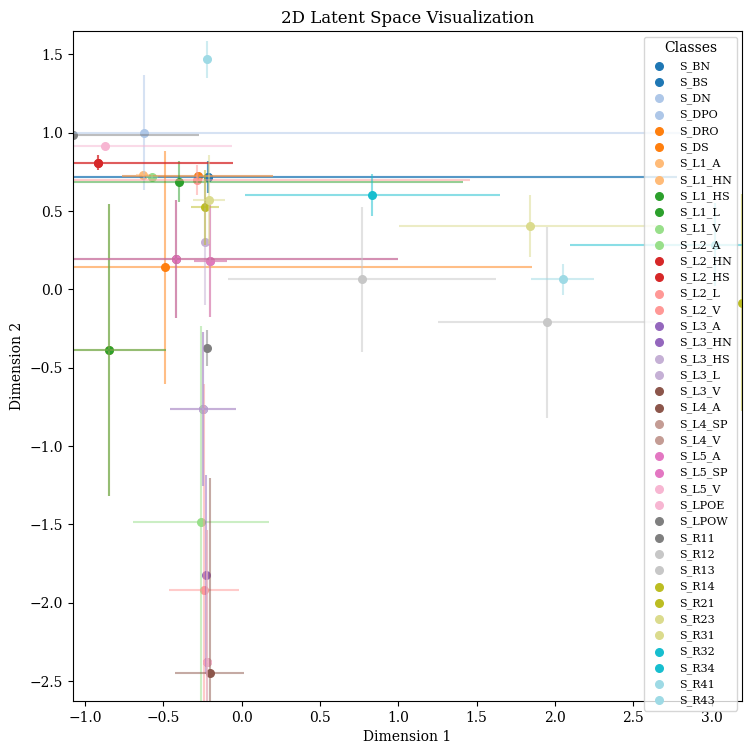

In [53]:
if len(features_used)==2:
    plot_2d_latent_space(feature_centroids,np.array(full_family_names), latent_stdevs=stdev_feature_centroids, save_path=family_feature_centroids_plot_path)

## Calculate distances

In [54]:
if data.shape[1] == 7:
    no_time_data = full_data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = full_data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(53, 6, 100)
(53, 6, 100)
(100, 6, 100)


### Orbit Distances

1. Nearest Orbit

In [ ]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation

In [ ]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

2. Generation vs Refinement

In [ ]:
pairwise_distances = calculate_pairwise_orbit_distances(no_time_generated_data_that_was_refined,
                                                        no_time_refined_orbits, distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances

### Point Distances

3. Distance from the centre

In [ ]:
# Latent space distance
centroid_distances = calculate_distances_batch(full_data_centroid, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['centroid_distance'] = centroid_distances

In [ ]:
# Feature distance
feature_centroid_distances = calculate_distances_batch(feature_centroid, refined_orbits_features, distance_metric=params['distance_metric'])
refined_orbits_df['feature_centroid_distance'] = feature_centroid_distances

4. Distance from centroids

In [ ]:
# Latent Space Centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_centroid_distance'] = closest_family_centroid_distance

In [ ]:
# Feature Space Centroids
closest_family_feature_centroid, closest_family_feature_centroid_distance = find_nearest_points_batch(refined_orbits_features, feature_centroids, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_feature_centroid'] = closest_family_feature_centroid
refined_orbits_df['closest_family_feature_centroid_distance'] = closest_family_feature_centroid_distance

5. Initial Conditions

In [ ]:
# Extract initial and final conditions
initial_conditions = refined_orbits_df[['initial_pos_x0', 'initial_pos_y0', 'initial_pos_z0',
                        'initial_vel_x0', 'initial_vel_y0', 'initial_vel_z0']].values
final_conditions = refined_orbits_df[['final_pos_x0', 'final_pos_y0', 'final_pos_z0',
                      'final_vel_x0', 'final_vel_y0', 'final_vel_z0']].values

ics_distances = calculate_pairwise_distances(initial_conditions, final_conditions, distance_metric=params['distance_metric'])
refined_orbits_df['initial_conditions_distance'] = ics_distances

## Export Features

In [ ]:
generation_df.to_csv(generation_df_path, index=False)
generation_df.shape

(100, 9)

In [ ]:
generation_df.head()

,position_error,velocity_error,energy_error,disorder_metric,correct_order,inversions,kendall_tau_distance,nearest_orbit,nearest_orbit_distance
0,0.117858,0.196755,0.264491,96.0,79.0,56.0,0.022626,18866,2.079341
1,0.293537,0.536004,1.663072,232.0,69.0,150.0,0.060606,19880,3.622663
2,0.316410,0.642480,0.867894,188.0,74.0,122.0,0.049293,30368,4.237964
3,0.121632,0.219787,0.237567,82.0,77.0,45.0,0.018182,27691,3.441835
4,0.327133,0.660935,0.335884,574.0,61.0,409.0,0.165253,8382,2.569475


In [ ]:
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(53, 47)

In [ ]:
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,disorder_metric.1,correct_order.1,inversions.1,kendall_tau_distance.1,disorder_metric,correct_order,inversions,kendall_tau_distance
0,0,6.681508,6.191982,6,4.006926e-10,1.043924,0.054178,0.089535,-0.069958,-0.541429,0.809974,1.068614,-0.062671,0.086892,-0.194351,-0.625872,0.883630,72.0,77.0,44.0,0.017778,2.047522e-12,1.169630e-11,4.985415e-11,0.074820,1.947843,0.489526,18870,0.000431,18875,1.727010,2.347987,0.281944,1.155201,14,0.235557,29,0.136187,0.205670,72.0,77.0,44.0,0.017778,72.0,77.0,44.0,0.017778
1,2,6.343020,6.310494,8,4.644930e-12,0.635513,-0.472652,0.313986,-0.619190,-1.407142,-0.532716,0.812518,-0.065665,0.576976,0.133974,-1.711637,-0.387909,168.0,78.0,102.0,0.041212,8.925106e-13,3.473907e-12,2.808833e-12,0.039650,-0.422727,0.032526,27145,0.000384,30386,6.760775,6.755768,1.516221,2.979801,25,0.144927,20,0.653509,0.973177,168.0,78.0,102.0,0.041212,168.0,78.0,102.0,0.041212
2,3,6.553319,6.301689,9,2.944897e-10,0.493051,0.341944,0.638089,-0.075344,-0.885442,0.536099,0.723095,0.438712,0.523782,-0.108172,-0.800060,0.828746,62.0,76.0,38.0,0.015354,7.601409e-12,1.895780e-11,9.551470e-11,0.027215,1.390312,0.251631,27652,0.000109,27694,2.351857,3.275253,0.558098,1.390368,22,0.312893,18,0.350182,0.411534,62.0,76.0,38.0,0.015354,62.0,76.0,38.0,0.015354
3,6,6.534883,6.230362,14,3.000276e-10,-1.439398,0.155306,1.246092,0.030485,0.879167,-0.010162,-1.317152,0.006900,1.221216,0.006212,0.991039,-0.001477,178.0,73.0,107.0,0.043232,1.775829e-12,7.277053e-12,8.471915e-12,0.066721,1.879466,0.304521,21937,0.000049,20909,3.031166,4.472930,1.361228,1.149586,16,0.030233,29,0.176090,0.225316,178.0,73.0,107.0,0.043232,178.0,73.0,107.0,0.043232
4,8,7.089235,6.189303,9,2.072527e-10,1.003943,-0.125944,-0.110756,-0.022212,-0.479927,-0.888967,0.892827,0.006733,0.015941,-0.002520,-0.425069,-1.006236,68.0,83.0,41.0,0.016566,3.055794e-12,8.617879e-12,8.542796e-13,0.035552,2.050338,0.899932,12479,0.000580,12483,1.313620,2.182510,0.989781,1.121241,9,0.139429,29,0.096500,0.251299,68.0,83.0,41.0,0.016566,68.0,83.0,41.0,0.016566


In [ ]:
not_to_show_columns = ['initial_pos_x0','initial_pos_y0','initial_pos_z0',	'initial_vel_x0',	'initial_vel_y0',	'initial_vel_z0	final_pos_x0',	'final_pos_y0',	'final_pos_z0',	'final_vel_x0',	'final_vel_y0',	'final_vel_z0', 'inversions',	'kendall_tau_distance' , 'closest_feature_indices',	'nearest_orbit', 'closest_family_centroid', 'closest_family_feature_centroid']

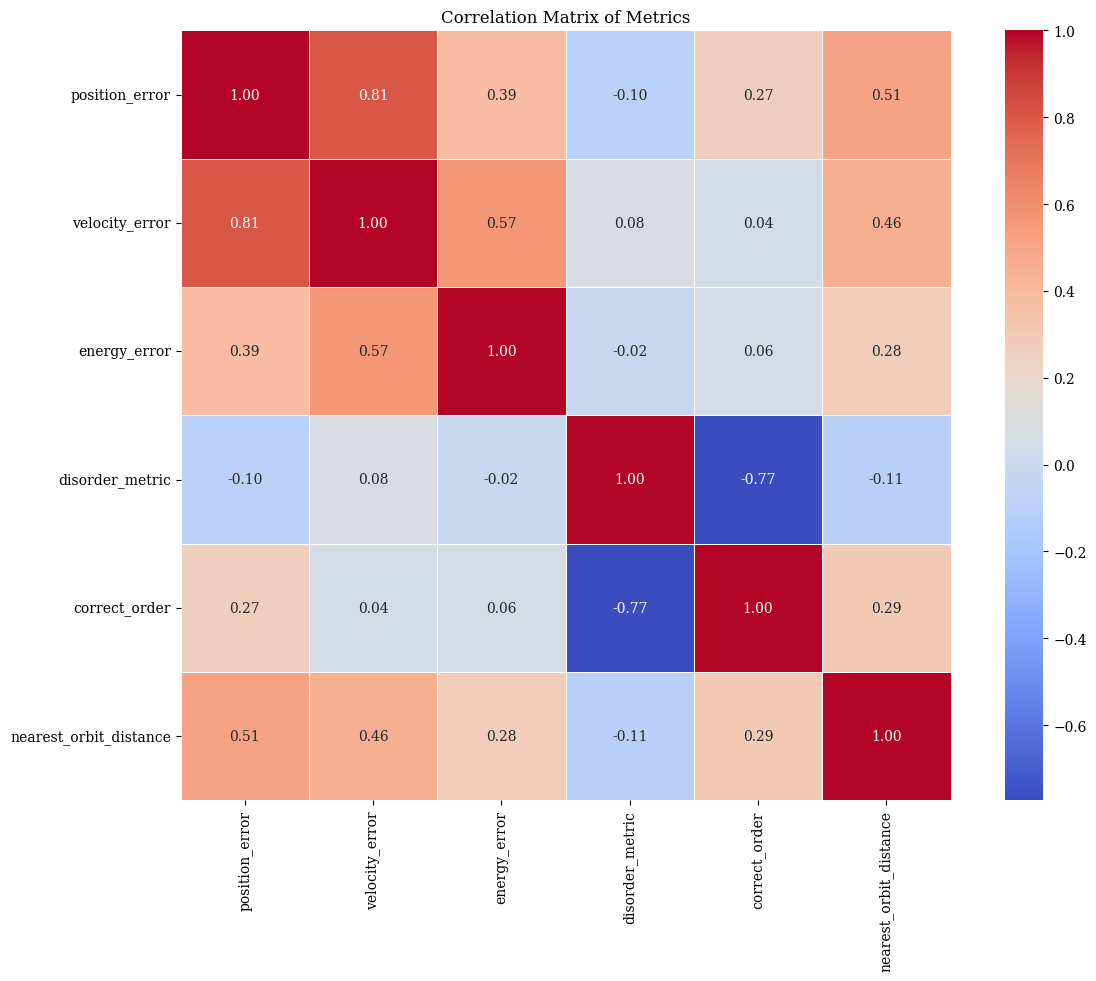

In [ ]:
plot_corr_matrix(generation_df.drop(columns=not_to_show_columns, errors='ignore'))

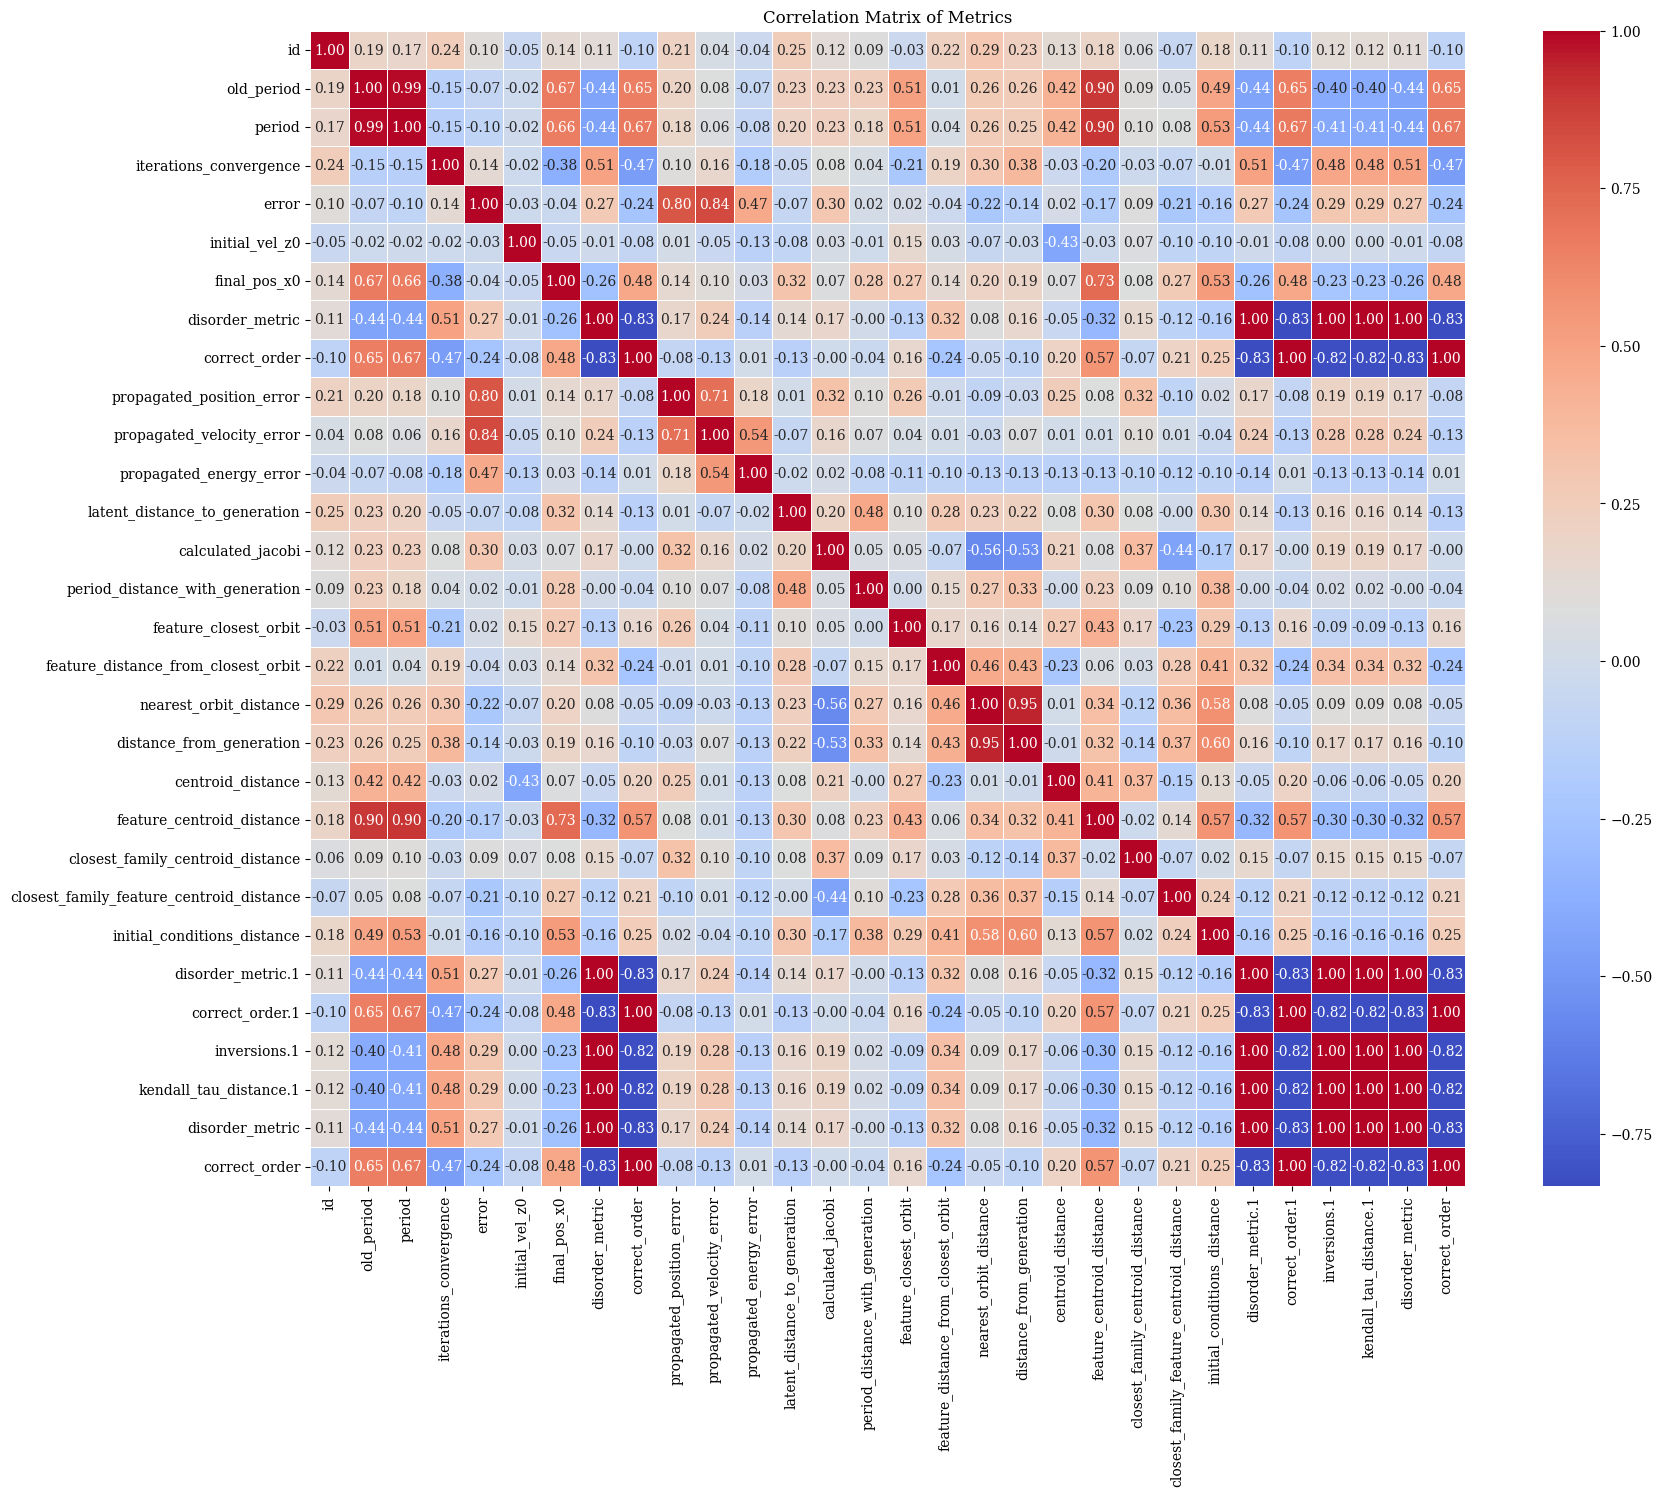

In [ ]:
plot_corr_matrix(refined_orbits_df.drop(columns=not_to_show_columns, errors='ignore'), figsize=(20,15))

# Intelligent Sampling

In [ ]:
# interpolate_sample(centroids, granularity=10, variance=0.0)

# Full Dataset Visualization

### Full Latent Space

In [ ]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
full_latent_means, full_latent_log_vars = model.encode(full_scaled_data)
full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [ ]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
len(family_labels_discarded_train)

45211

In [ ]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

Saved plot to ../experiments/experiment_16/images/exp16_full_latent_space


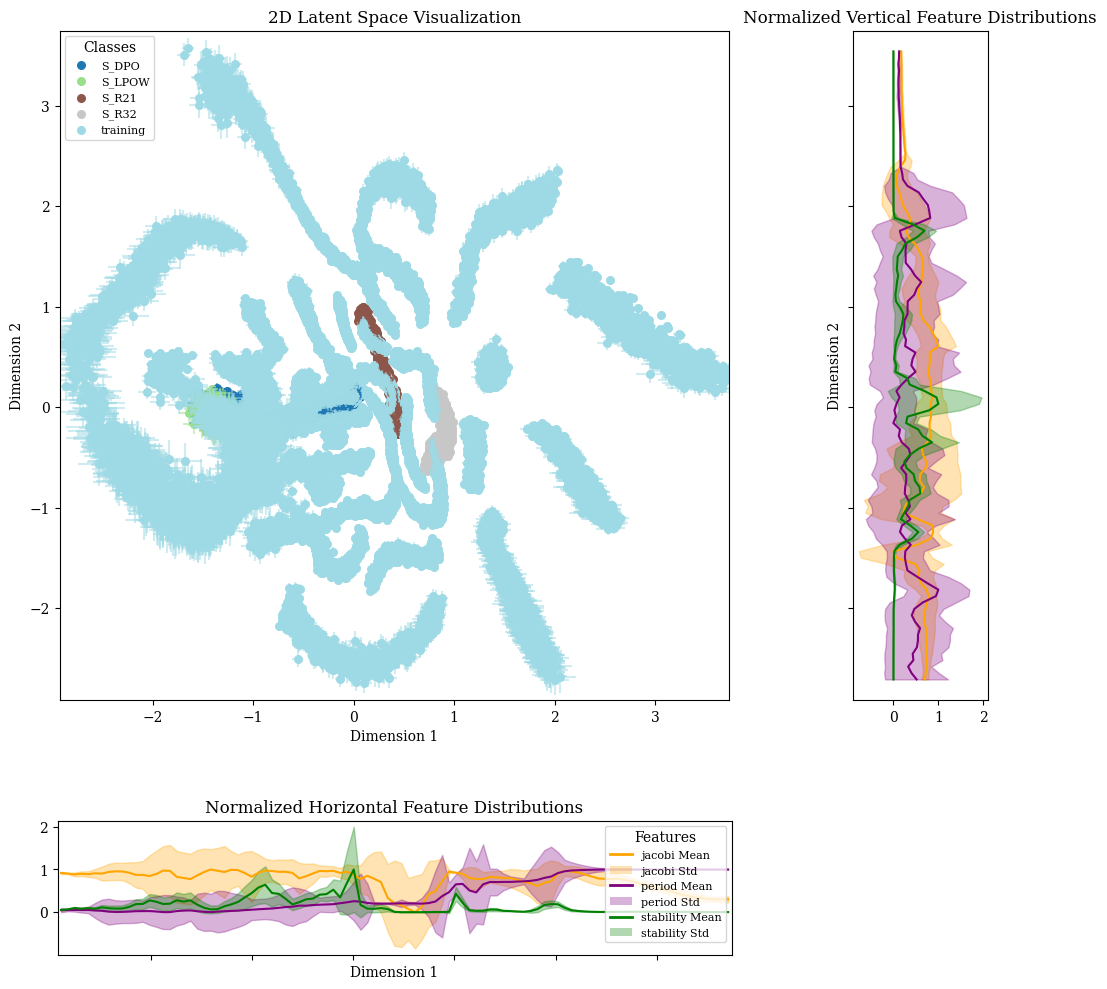

In [ ]:
if full_latent_means.shape[1]==2:
    plot_2d_latent_space(full_latent_means,
                            np.array(family_labels_discarded_train),
                            save_path=full_latent_space_path,
                            features=full_features,
                            feature_names=feature_names,
                            plot_std=True,
                            latent_stdevs=full_latent_stdevs)

### Full Centroids

In [ ]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [ ]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [ ]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
len(families_discarded_train)

40

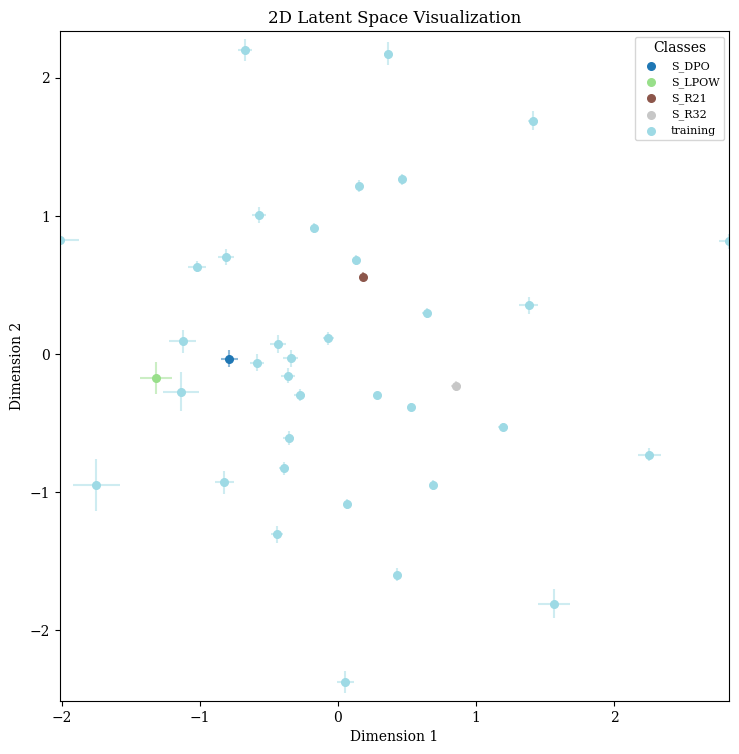

In [ ]:
if full_centroid_means.shape[1]==2:
    plot_2d_latent_space(full_centroid_means,
                            np.array(families_discarded_train),
                            save_path=full_family_centroids_plot_path,
                            latent_stdevs=full_centroid_stdevs
                            )

## Calculate Full Centroid Distances

In [ ]:
# Recalculate distance from latent space centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, full_centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_full_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_full_centroid_distance'] = closest_family_centroid_distance

# Intelligent Sampling

# Check Discovery

In [ ]:
orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0


In [ ]:
family_mapping = orbit_df['id_class'].to_dict()

def get_class_name(orbit_id):
    return family_mapping.get(orbit_id, None)

refined_orbits_df['family_of_feature_closest_orbit'] = refined_orbits_df['feature_closest_orbit'].apply(get_class_name)
refined_orbits_df['family_of_closest_orbit'] = refined_orbits_df['nearest_orbit'].apply(get_class_name)
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

In [ ]:
family_columns = ['family_of_feature_closest_orbit', 'family_of_closest_orbit', 'closest_family_feature_centroid','closest_family_full_centroid']
filter_condition = refined_orbits_df[family_columns].isin(discarded_family_ids).any(axis=1)
close_discovery_df = refined_orbits_df[filter_condition]
close_discovery_df.shape

(5, 51)

In [ ]:
close_discovery_df[family_columns].head()

,family_of_feature_closest_orbit,family_of_closest_orbit,closest_family_feature_centroid,closest_family_full_centroid
28,33.0,33.0,36,30
31,34.0,34.0,34,31
34,34.0,34.0,31,31
44,34.0,34.0,39,31
46,34.0,34.0,39,31


In [ ]:
filter_condition = refined_orbits_df[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
discovery_df = refined_orbits_df[filter_condition]
discovery_df.shape

(0, 51)

In [ ]:
discovery_df[family_columns].head()

,family_of_feature_closest_orbit,family_of_closest_orbit,closest_family_feature_centroid,closest_family_full_centroid
